# Assignment 3

In [1]:
import os
import numpy as np
import pandas as pd

import albumentations as A                       # a great library for image data augmentation and processing 
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,ConcatDataset,SubsetRandomSampler

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import mean_squared_error as mse

import math

import glob

import cv2

## base params once moved to .py format these will be CL arguments
x_input_dir = '../input/dataset/VOCdevkit 2/VOC2007'
y_mid_input_dir = '../input/dataset-1/VOCdevkit 2/VOC2007'
y_larage_input_dir = '../input/dataset-2/VOCdevkit 2/VOC2007'
epochs = 10
batch_size = 64 #batch of photos in every epochs
small_size = 72
mid_size = 144
large_size = 288
seed = 2020 #control random



use_cuda = torch.has_cuda

if use_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

print('active device',device)
print('me')

## Step 1 - Prepare the Data 

In [2]:
x_train = glob.glob(x_input_dir + '/JPEGImages' + '/*.jpg')
x_train.sort()
x_train[:5],x_train[1000:1005]

In [3]:
y_mid_train = glob.glob(y_mid_input_dir + '/JPEGImages' + '/*.jpg')
y_mid_train.sort()
y_mid_train[:5],y_mid_train[1000:1005]

In [4]:
y_large_train = glob.glob(y_larage_input_dir + '/JPEGImages' + '/*.jpg')
y_large_train.sort()
y_large_train[:5],y_large_train[1000:1005]

In [5]:
def image_resizer(img_set, size):
    res = []
    for path in img_set:
        img = cv2.imread(path)
        res.append(cv2.resize(img,(size,size)))
    return res    

Resize all of the images before the training to save time

In [6]:
x_train_img = image_resizer(x_train, small_size)
x_train_img[1].shape

In [7]:
y_mid_train_img = image_resizer(y_mid_train, mid_size)
y_mid_train_img[1].shape

In [8]:
y_large_train_img = image_resizer(y_large_train, large_size)
y_large_train_img[1].shape

In [9]:
transforms = A.Compose([ToTensorV2()])

In [10]:
len(x_train_img)

In [11]:
class ImageDataset(Dataset):
    def __init__(self,x_train_img, y_mid_train_img, y_large_train_img, transforms=None):
        self.x_img = x_train_img
        self.y_mid_img = y_mid_train_img
        self.y_large_img = y_large_train_img
        self.transforms = transforms
        
    def __len__(self):
        return len(self.x_img)
    
    def __getitem__(self,idx):
        x = self.x_img[idx]
        x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
        y_mid = self.y_mid_img[idx]
        y_mid = cv2.cvtColor(y_mid,cv2.COLOR_BGR2RGB)
        y_large = self.y_large_img[idx]
        y_large = cv2.cvtColor(y_large,cv2.COLOR_BGR2RGB)
        if not self.transforms is None:
            transformed_x = self.transforms(image=x)
            x = transformed_x['image']
            transformed_y_mid = self.transforms(image=y_mid)
            y_mid = transformed_y_mid['image']
            transformed_y_large = self.transforms(image=y_large)
            y_large = transformed_y_large['image']
            
        return x,y_mid,y_large

In [12]:
N = 1000
train_dataset = ImageDataset(x_train_img[N:], y_mid_train_img[N:], y_large_train_img[N:], transforms)
val_dataset = ImageDataset(x_train_img[:N], y_mid_train_img[:N], y_large_train_img[:N], transforms)

In [13]:
import matplotlib.pyplot as plt
def display_image(images):
    %matplotlib inline
    fig, ax = plt.subplots(1,3,figsize=(20,20))
    plt.subplots_adjust(hspace=1)
    labels = ['x_train', 'y_mid_train', 'y_large_train']
    for i in range(3):
        label = labels[i] #get the label
        img = images[i]
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #fix colors
        ax[i%3].imshow(img)
        ax[i%3].set_title(label)

In [14]:
idx = 5
display_image([x_train_img[idx], y_mid_train_img[idx], y_large_train_img[idx]])

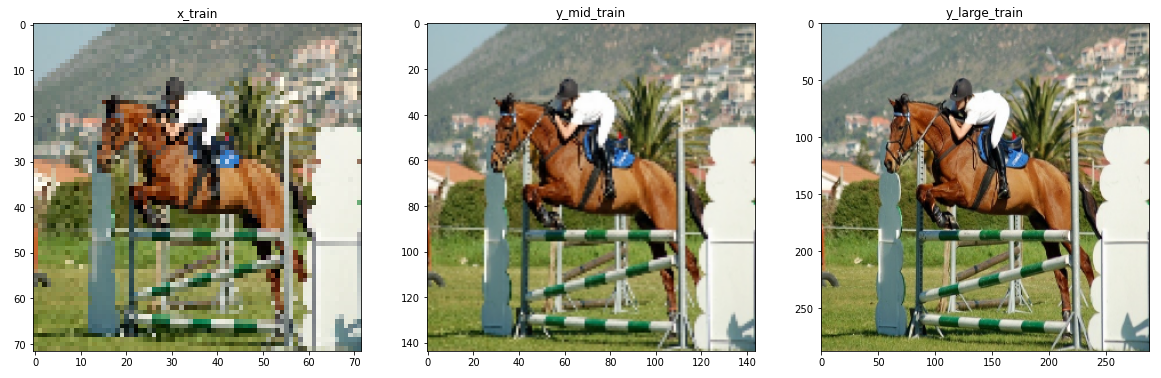

In [15]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

## Step 2 - Create an initial model

In [16]:
class InitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 2) 
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 2)
        self.upsempl = nn.UpsamplingBilinear2d(size = [mid_size, mid_size])
        
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.conv2(x))
        x = self.upsempl(x)
        x = self.dropout1(x)
        x = self.relu(self.conv3(x))
       
        return x

In [17]:
model1 = InitModel().to(device)
model1

In [19]:
def psnr(label, outputs, max_val=255.0):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean(img_diff ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [27]:
import time
def _train(tr_loader,val_loader,model,idx):
    start = time.time()
    trainin_logs = []
    learning_rate = 5e-3
    mid_img = None
    criterion = nn.L1Loss()
    params_list = [{'params':model.parameters(),'lr':learning_rate}]
    optimizer = optim.Adam(params=params_list)
    
    for epoch in range(epochs):
        model.train()
        tr_loss = 0
        PSNR = 0

        for step, batch in enumerate(tr_loader):
            imgs, mid_labels, dont_care = batch
            imgs = imgs.to(device).float()
            mid_labels = mid_labels.to(device).long()
        
            outputs = model(imgs)
            
            loss = criterion(outputs.float(), mid_labels.float())
            loss.backward()
            tr_loss += loss.item()
            
            PSNR += psnr(outputs.float(), mid_labels.float())
            
            optimizer.step()
            optimizer.zero_grad()
            
        
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None
        
        for step, batch in enumerate(val_loader):
            imgs, mid_labels, dont_care = batch
                
            imgs = imgs.to(device).float()
            mid_labels = mid_labels.to(device).long()
            
            with torch.no_grad():
                outputs = model(imgs)
                
                loss = criterion(outputs.float(),mid_labels.float())
                val_loss += loss.item()
                
                predictions = outputs.data.cpu()
                
                if val_preds is None:
                    val_preds = predictions
                else:
                    val_preds = torch.cat((val_preds,predictions),dim=0)

                    
        if mid_img is None:
            mid_img = val_preds[idx]
        else:
            mid_img = torch.cat((mid_img,val_preds[idx]),dim=0)
        
        train_loss = (tr_loss / len(train_loader))
        validation_loss = (val_loss / len(val_loader))
        train_psnr = (PSNR / len(train_loader))
        metrics = {
            'epoch':epoch,
            'train_loss':train_loss,
            'train_psnr':train_psnr,
            'validation_loss':validation_loss
            }
        trainin_logs.append(metrics)
        print("Epoch:{}/{} Training Loss:{:.3f} Validation Loss:{:.3f} Train PSNR:{:.2f}".format(epoch + 1,
                                                                                            epochs,
                                                                                            train_loss,
                                                                                            validation_loss,
                                                                                            train_psnr))
        print ("Total time: ", time.time() - start, "seconds")
    return trainin_logs, mid_img

In [28]:
train_log, mid_img = _train(train_loader,val_loader,model1,1)

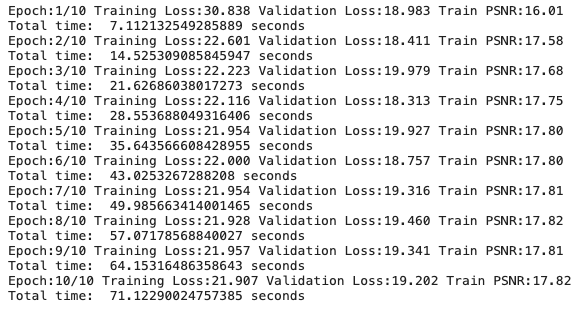

In [20]:
def plot_loss(train_log):
    train_loss_list = []
    val_loss_list = []
    for i in range(5):
        train_loss_list.append(train_log[i]['train_loss']) 
        val_loss_list.append(train_log[i]['validation_loss'])
    plt.plot(train_loss_list,label = 'train_loss')
    plt.plot(val_loss_list, label = 'val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [30]:
plot_loss(train_log)

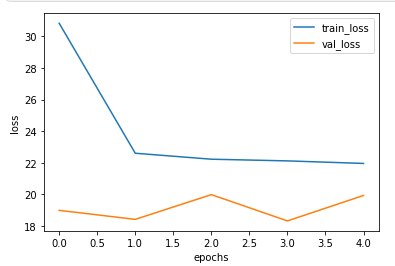

It can be seen that the training loss decrese at every epoch, but the validation loss goes up and down, could be a problem with the learning rate. overall the validation loss was lower then train loss at all times. 

In [21]:
def plot_psnr(train_log):
    train_psnr_list = []
    for i in range(5):
        train_psnr_list.append(train_log[i]['train_psnr']) 
    plt.plot(train_psnr_list,label = 'train_PSNR')
    plt.xlabel('epochs')
    plt.ylabel('psnr')
    plt.legend()
    plt.show()

In [33]:
plot_psnr(train_log)

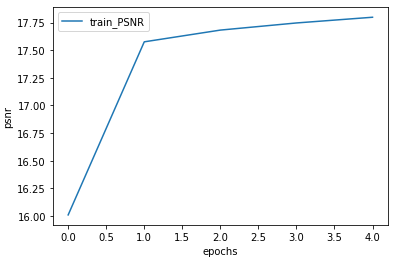

The PSNR increases at every epoch, so it looks like the model did learn

In [22]:
def tensor_to_numpy(img,idx):
    r = torch.unsqueeze(img[idx],2)
    g = torch.unsqueeze(img[idx+1],2)
    b = torch.unsqueeze(img[idx+2],2)
    cat_img = torch.cat((r,g,b),2)
    numpy_img = np.transpose(cat_img.float().numpy(),axes=[0,1,2])
    return numpy_img

In [23]:
def plot_image_per_epochs(img):     
    fig, ax = plt.subplots(2, 5, figsize=(15,7))
    plt.subplots_adjust(hspace=0.4)
    row = 0
    for i in range(epochs):
        fixed_img = tensor_to_numpy(img, i*3)
        fixed_img /= 255.0
        if (i>4): row = 1
        ax[row,i%5].imshow(fixed_img)
        ax[row,i%5].set_title(f'Epoch {i+1}')

In [36]:
plot_image_per_epochs(mid_img)

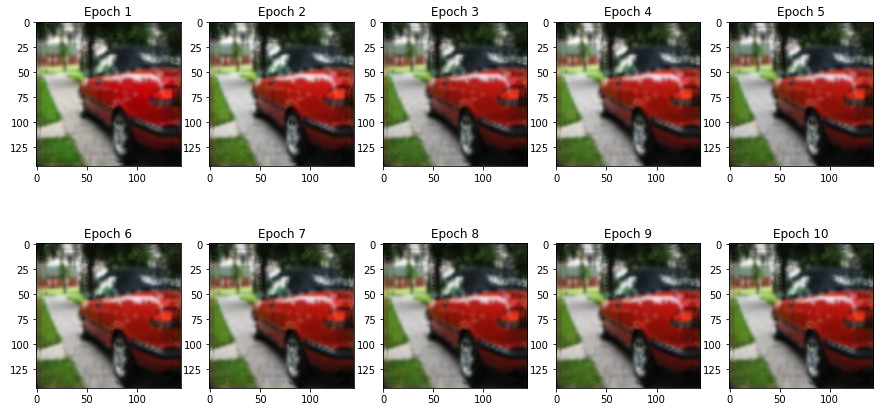

## Step 3 - Add block to the initial model

In [39]:
class Second_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 2) 
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding =2)
        self.upsempl = nn.UpsamplingBilinear2d(size = [mid_size, mid_size])
        self.upsempl2 = nn.UpsamplingBilinear2d(size = [large_size, large_size])
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.conv2(x))
        x = self.upsempl(x)
        x = self.dropout1(x)
        mid = self.relu(self.conv3(x))
        y = self.relu(self.conv2(x))
        y = self.upsempl2(y)
        y = self.dropout2(y)
        large = self.relu(self.conv4(y))
       
        return mid, large

In [49]:
model2 = Second_Model().to(device)
model2

In [24]:
import time
def _train2(tr_loader,val_loader,model,idx):
    start = time.time()
    trainin_logs = []
    learning_rate = 5e-3
    mid_img = None
    large_img = None
    is_img_empty = True
    criterion = nn.L1Loss()
    params_list = [{'params':model.parameters(),'lr':learning_rate}]
    optimizer = optim.Adam(params=params_list)
    
    for epoch in range(epochs):
        model.train()
        tr_loss = 0
        PSNR = 0
        
        for step, batch in enumerate(tr_loader):
            imgs, mid_labels, large_labels = batch
            imgs = imgs.to(device).float()
            mid_labels = mid_labels.to(device).long()
            large_labels = large_labels.to(device).long()
            
            outputs = model(imgs)
            
            mid_loss = criterion(outputs[0].float(), mid_labels.float())
            large_loss = criterion(outputs[1].float(), large_labels.float())
            loss = (mid_loss + large_loss) / 2
            loss.backward()
            tr_loss += loss.item()
            
            mid_psnr = psnr(outputs[0].float(), mid_labels.float())
            large_psnr = psnr(outputs[1].float(), large_labels.float())
            PSNR += (mid_psnr + large_psnr)/2
            
            optimizer.step()
            optimizer.zero_grad()
            
           
        model.eval()
        val_loss = 0
        val_preds_mid = None
        val_preds_large = None
        is_preds_empty = True
        
        for step, batch in enumerate(val_loader):
            imgs, mid_labels, large_labels = batch
            imgs = imgs.to(device).float()
            mid_labels = mid_labels.to(device).long()
            large_labels = large_labels.to(device).long()
            
            with torch.no_grad():
                outputs = model(imgs)
                
                mid_loss = criterion(outputs[0].float(), mid_labels.float())
                large_loss = criterion(outputs[1].float(), large_labels.float())
                loss = (mid_loss + large_loss) / 2
                val_loss += loss.item()
                
                predictions = outputs
                
                if is_preds_empty:
                    val_preds_mid = predictions[0].data.cpu()
                    val_preds_large = predictions[1].data.cpu()
                    is_preds_empty = False
                else:
                    val_preds_mid = torch.cat((val_preds_mid,predictions[0].data.cpu()),dim=0)
                    val_preds_large = torch.cat((val_preds_large,predictions[1].data.cpu()),dim=0)
               
        if is_img_empty:
            mid_img = val_preds_mid[idx]
            large_img = val_preds_large[idx]
            is_img_empty = False
        else:
            mid_img = torch.cat((mid_img,val_preds_mid[idx]),dim=0)
            large_img = torch.cat((large_img,val_preds_large[idx]),dim=0)
            
        train_loss = (tr_loss / len(train_loader))
        validation_loss = (val_loss / len(val_loader))
        train_psnr = (PSNR / len(train_loader))    
        metrics = {
            'epoch':epoch,
            'train_loss':train_loss,
            'train_psnr':train_psnr,
            'validation_loss':validation_loss
            }
        trainin_logs.append(metrics)
        print("Epoch:{}/{} Training Loss:{:.3f} Validation Loss:{:.3f} Train PSNR:{:.2f}".format(epoch + 1,
                                                                                            epochs,
                                                                                            train_loss,
                                                                                            validation_loss,
                                                                                            train_psnr))
        print ("Total time: ", time.time() - start, "seconds")
    return trainin_logs, mid_img, large_img

In [53]:
train_logs2, mid_img2, large_img2 = _train2(train_loader,val_loader,model2,1)

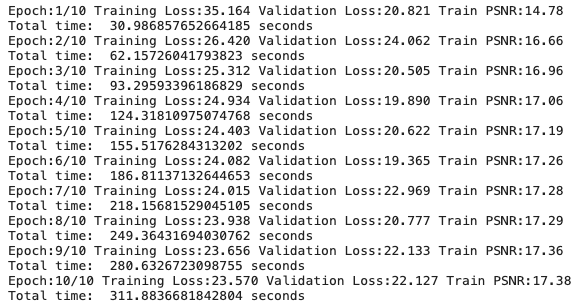

In [55]:
plot_loss(train_logs2)

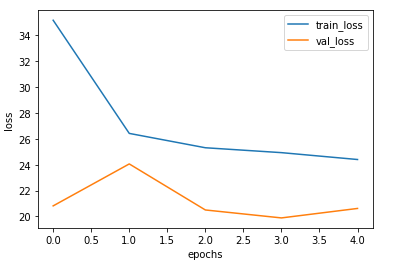

The validation loss decreased at most of the time, looked better than the first model. The train loss is decreasing every epoch.

In [58]:
plot_psnr(train_logs2)

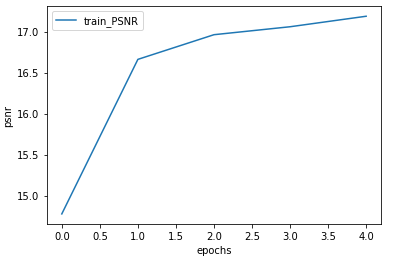

The PSNR was increasing at every epoch and got to same results as the previous model

In [59]:
plot_image_per_epochs(mid_img2)

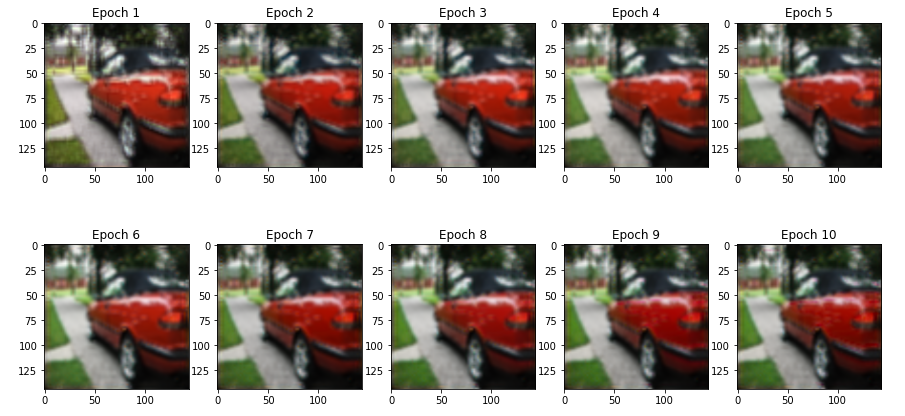

In [60]:
plot_image_per_epochs(large_img2)

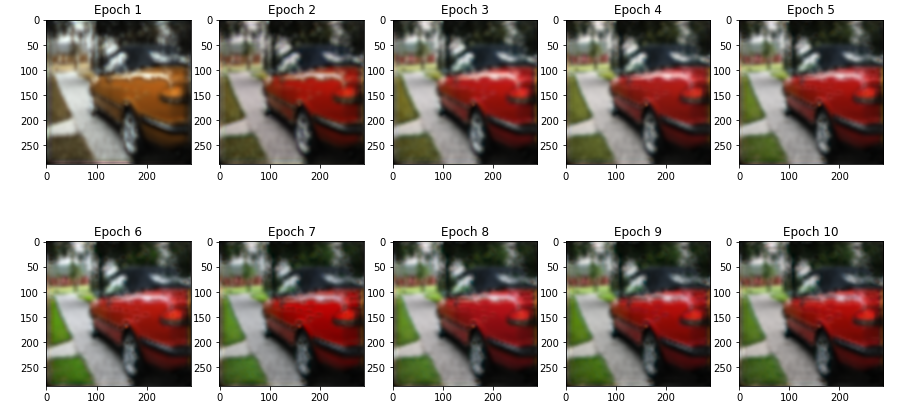

After the first two epochs the images got weird colors, but as the model continue the colors got better

## Step 4 - Add residual block

In [62]:
class ThirdModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 1)
        self.resblock1 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1), nn.ReLU(),
                                      nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1), nn.ReLU())
        self.resblock2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1), nn.ReLU(),
                                      nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1), nn.ReLU())
        self.upsempl = nn.UpsamplingBilinear2d(size = [mid_size, mid_size])
        self.upsempl2 = nn.UpsamplingBilinear2d(size = [large_size, large_size])
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv1(x)
        temp = self.resblock1(x)
        x = torch.add(x,temp)
        #mid
        x = self.relu(x)
        x = self.upsempl(x)
        x = self.dropout1(x)
        mid = self.relu(self.conv3(x))
        #large
        temp = self.resblock2(x)
        x = torch.add(x,temp)
        x = self.relu(x)
        x = self.upsempl2(x)
        x = self.dropout2(x)
        large = self.relu(self.conv4(x))
       
        return mid, large

In [63]:
model3 = ThirdModel().to(device)
model3

In [64]:
train_logs3, mid_img3, large_img3 = _train2(train_loader,val_loader,model3,1)

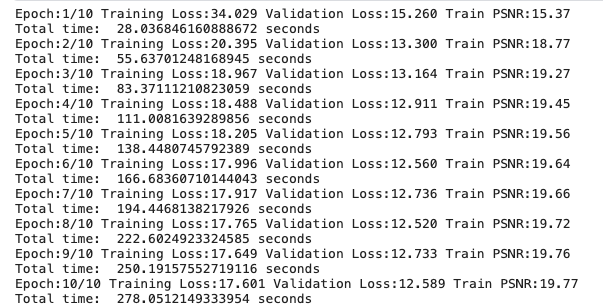

In [65]:
plot_loss(train_logs3)

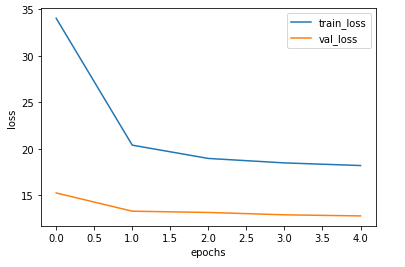

In this model it was the first time that the validation loss was decreasing at every epoch.
The train loss was going down as it did in previous models.

In [66]:
plot_psnr(train_logs3)

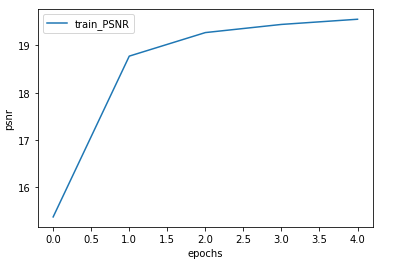

The PSNR was increasing at every epoch and got better results then the two previous models.

In [68]:
plot_image_per_epochs(mid_img3)

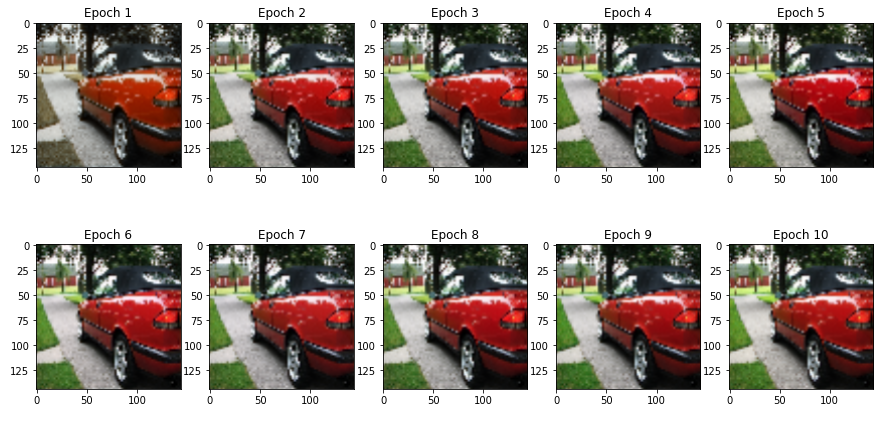

In [69]:
plot_image_per_epochs(large_img3)

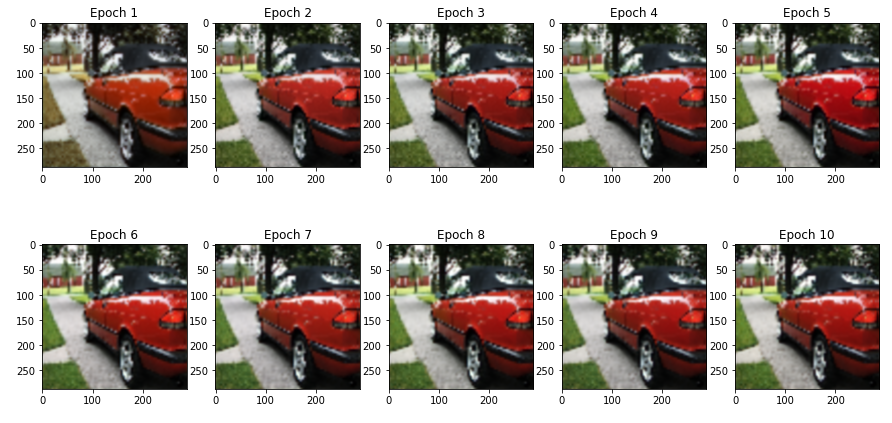

It can be seen that this model got better result than the previous two, the images are less blury.

## Step 5 - Replace residual block with dilated (Atrous) convolutional block 

In [70]:
class AtrousBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.dilation1 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 1, padding = 1)
        self.dilation2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 2, padding = 2)
        self.dilation3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 4, padding = 4) 
        self.relu = nn.LeakyReLU()
        self.conv = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, padding = 1)
        
    def forward(self, x):
        dial1 = self.dilation1(x)
        dial2 = self.dilation2(x)
        dial3 = self.dilation3(x)
        x = torch.cat((dial1, dial2, dial3), dim =1)
        x = self.relu(x)
        x = self.conv(x)
        
        return x

In [71]:
class ForthModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 1)
        #self.dilation1 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 1, padding = 1),
        #                              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 2, padding = 2),
        #                              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 4, padding = 4), nn.LeakyReLU())
        #self.dilation2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 1, padding = 1),
        #                              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 2, padding = 2),
        #                              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 4, padding = 4), nn.LeakyReLU())
        #self.dilation3 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 1, padding = 1),
        #                              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 2, padding = 2),
        #                              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 4, padding = 4), nn.LeakyReLU())
        self.dilation1 = AtrousBlock()
        self.dilation2 = AtrousBlock()
        self.dilation3 = AtrousBlock()
        self.upsempl = nn.UpsamplingBilinear2d(size = [mid_size, mid_size])
        self.upsempl2 = nn.UpsamplingBilinear2d(size = [large_size, large_size])
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 1)
        self.relu = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.dilation1(x)
        x = self.dilation2(x)
        #mid
        x = self.upsempl(x)
        x = self.dropout1(x)
        mid = self.relu(self.conv3(x))
        #large
        x = self.dilation3(x)
        x = self.upsempl2(x)
        x = self.dropout2(x)
        large = self.relu(self.conv4(x))
       
        return mid, large

In [72]:
model4 = ForthModel().to(device)
model4

In [73]:
train_logs4, mid_img4, large_img4 = _train2(train_loader,val_loader,model4,1)

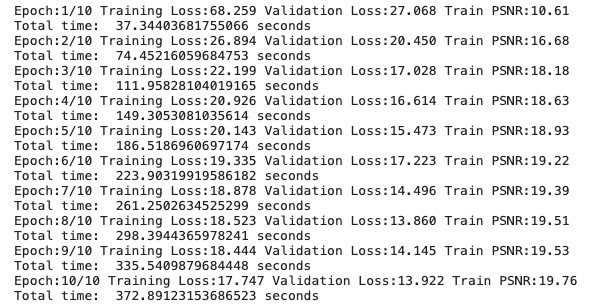

In [74]:
plot_loss(train_logs4)

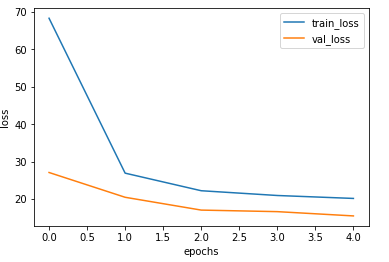

The validation and train loss were both decreasing which is great :)

In [75]:
plot_psnr(train_logs4)

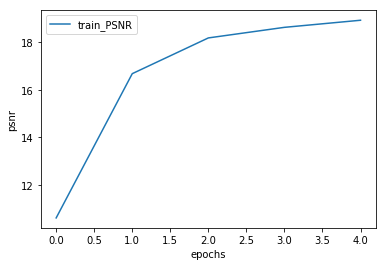

The PSNR was increasing every epoch but the results were better at the previous model.

In [76]:
plot_image_per_epochs(mid_img4)

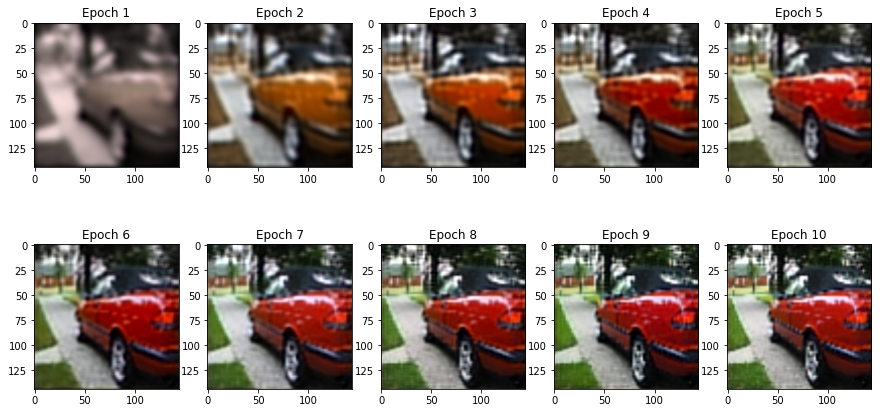

In [77]:
plot_image_per_epochs(large_img4)

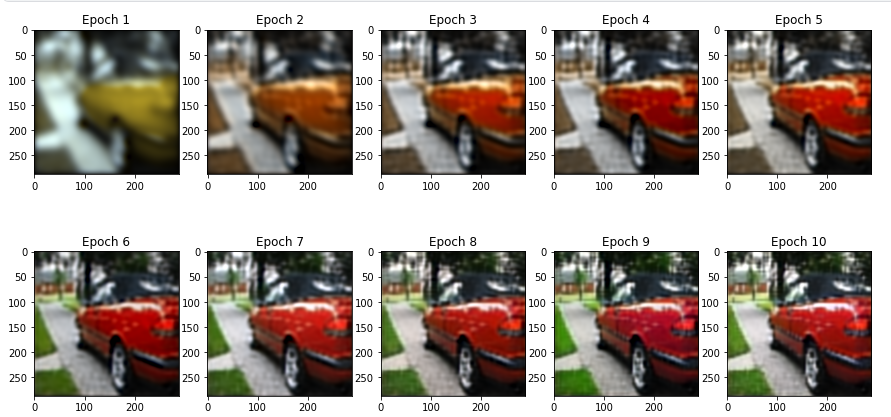

For some reason the middle image was grey at first but with each epoch the colors got better. The large image started very blurry with weird colors but with every epoch got better.

## Step 6 - Pretrained model

In [78]:
class FifthModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        for param in self.vgg16.parameters():
             param.requires_grad = False
        self.featextr = self.vgg16.features[:3]
        self.upsempl = nn.UpsamplingBilinear2d(size = [mid_size, mid_size])
        self.upsempl2 = nn.UpsamplingBilinear2d(size = [large_size, large_size])
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        extrc = self.featextr(x)
        x = self.conv1(x)
        x = self.relu(self.conv2(x))
        x = torch.cat((x,extrc), dim =1)
        #mid
        x = self.upsempl(x)
        x = self.dropout1(x)
        mid = self.relu(self.conv3(x))
        #large
        x = self.upsempl2(x)
        x = self.dropout2(x)
        large = self.relu(self.conv4(x))
       
        return mid, large

In [79]:
model5 = FifthModel().to(device)
model5

In [80]:
train_logs5, mid_img5, large_img5 = _train2(train_loader,val_loader,model5,1)

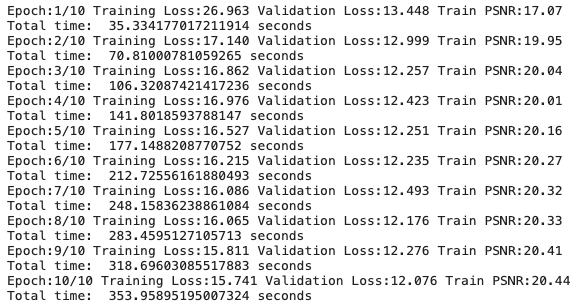

In [81]:
plot_loss(train_logs5)

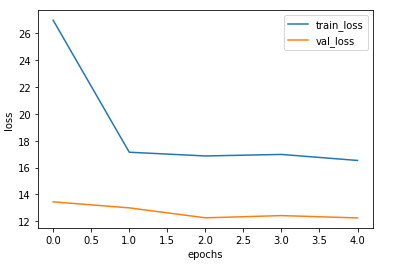

With the VGG16 net the train loss dropped very fast at start and got stabled. The validation loss starts low and dropped a little.

In [82]:
plot_psnr(train_logs5)

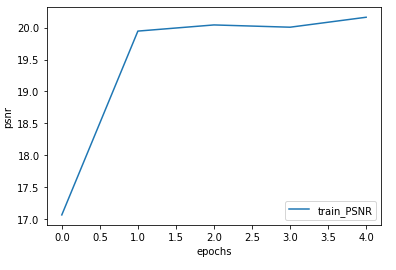

This model got the higher PSNR result

In [83]:
plot_image_per_epochs(mid_img5)

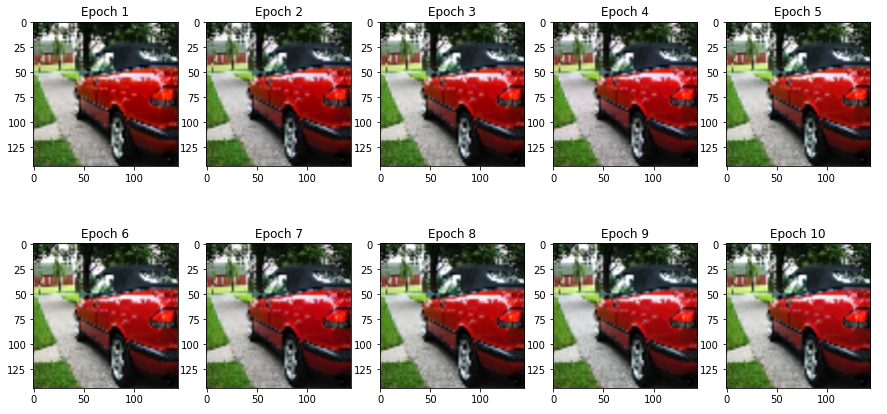

In [84]:
plot_image_per_epochs(large_img5)

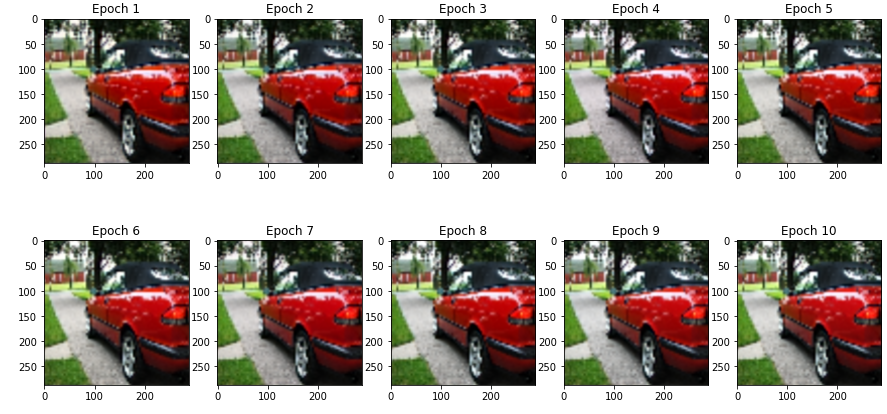

This model was less blurry than the other models, and the colors were correct through the whole epochs.

## Step 8 - Improve one of the above models

I decided to combine two models, the pretrained vgg16 and the residual-block model

In [16]:
class FinalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv1_bn=nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv2_bn=nn.BatchNorm2d(64)
        self.resblock1 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1), nn.ReLU(),
                                      nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1), nn.ReLU())
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        for param in self.vgg16.parameters():
             param.requires_grad = False
        self.featextr = self.vgg16.features[:3]
        self.upsempl = nn.UpsamplingBilinear2d(size = [mid_size, mid_size])
        self.upsempl2 = nn.UpsamplingBilinear2d(size = [large_size, large_size])
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 1)
        #self.conv3_bn=nn.BatchNorm2d(3)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 1)
        #self.conv4_bn=nn.BatchNorm2d(3)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        extrc = self.featextr(x)
        x = self.conv1(x)
        temp = self.resblock1(x)
        x = torch.add(x,temp)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = torch.cat((x,extrc), dim =1)
        #mid
        x = self.upsempl(x)
        x = self.dropout1(x)
        mid = self.relu(self.conv3(x))
        #large
        x = self.upsempl2(x)
        x = self.dropout2(x)
        large = self.relu(self.conv4(x))
       
        return mid, large

In [17]:
model6 = FinalModel().to(device)
model6

In [31]:
train_logs6, mid_img6, large_img6 = _train2(train_loader,val_loader,model6,1)

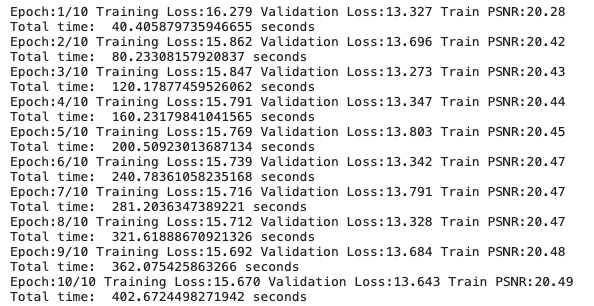

In [32]:
train_logs6

In [33]:
plot_loss(train_logs6)

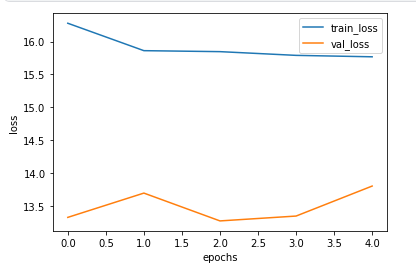

Also the validation loss was lower than the train loss but it looks like the loss was increasing most of the time and the train loss is decreasing. So the model could got overfit.

In [34]:
plot_psnr(train_logs6)

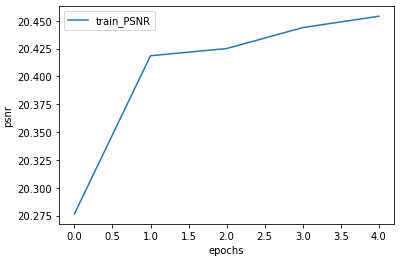

Still this model got the best PSNR results. 

In [35]:
plot_image_per_epochs(mid_img6)

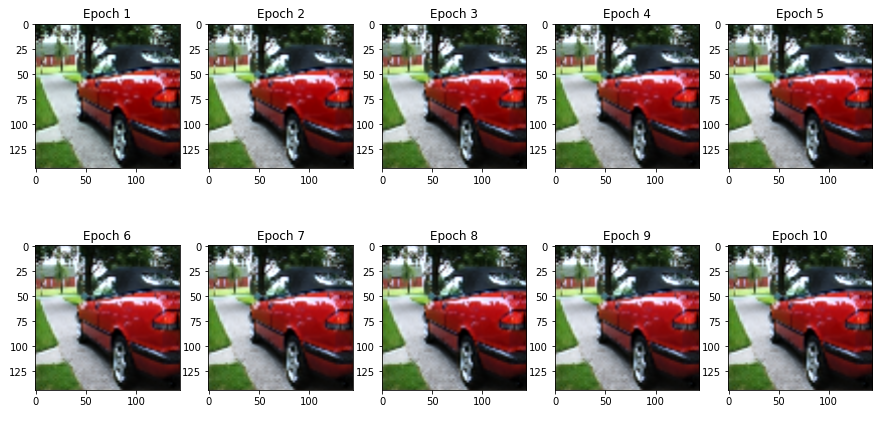

In [36]:
plot_image_per_epochs(large_img6)

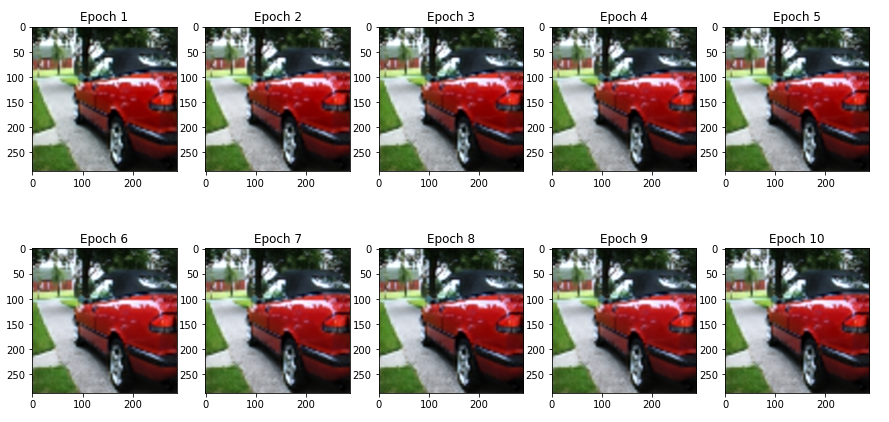

As we seen in the previous model, the images was less blurry then in the others model and the colors were good at all times.

In [62]:
def plot_last_img(img,label):     
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    plt.subplots_adjust(hspace=0.4)
    row = 0
    for i in range(1):
        fixed_img = tensor_to_numpy(img, i*27)
        fixed_img /= 255.0
        ax.imshow(fixed_img)
        ax.set_title(label)

In [63]:
plot_last_img(mid_img6, "y_mid")

In [64]:
plot_last_img(large_img6, "y_large")

In [ ]:
!pip install prettytable 

In [38]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Model", "Name", "Run time", "Init image size", "Final image size"]) 
  
# Add rows 
myTable.add_row(["1", "Simple 72 -> 144", "71.122 sec", "72", "144"]) 
myTable.add_row(["2", "Full 72 -> 288", "311.883 sec", "72", "288"]) 
myTable.add_row(["3", "Residual block", "278.051 sec", "72", "288"]) 
myTable.add_row(["4", "Dilated conv block","372.891 sec", "72", "288"]) 
myTable.add_row(["5", "Pretrained vgg16","353.958 sec", "72", "288"]) 
myTable.add_row(["6", "Residual + Pretrained vgg16","402.672 sec", "72", "288"]) 
  
print(myTable)

myTable3 = PrettyTable(["Model", "Max Train Loss", "Min Train Loss", "Max Val Loss", "Min Val Loss"]) 
  
# Add rows 
myTable3.add_row(["1", "30.838", "21.907", "19.979", "18.411"]) 
myTable3.add_row(["2", "35.163", "23.569", "24.061", "19.364"]) 
myTable3.add_row(["3", "34.029", "17.601", "15.260", "12.520"]) 
myTable3.add_row(["4", "68.259", "17.746", "27.068", "13.860"]) 
myTable3.add_row(["5", "26.962", "15.741", "13.447", "12.075"]) 
myTable3.add_row(["6", "16.279", "15.669", "13.803", "13.272"]) 
  
print(myTable3)

myTable2 = PrettyTable(["Model", "Max PSNR", "Min PSNR"]) 
  
# Add rows 
myTable2.add_row(["1", "17.819", "16.008"]) 
myTable2.add_row(["2", "17.382", "14.777"]) 
myTable2.add_row(["3", "19.773", "15.366"]) 
myTable2.add_row(["4", "19.759", "10.614"])
myTable2.add_row(["5", "20.435", "17.066"]) 
myTable2.add_row(["6", "20.49", "20.276"])
  
print(myTable2)

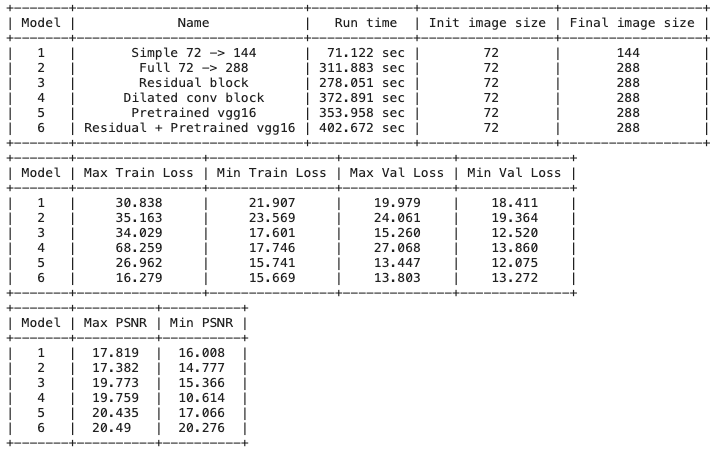